In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [2]:
def readCsvToDF(path):
    dataSeries = pd.read_csv(path)
    dataSeries = dataSeries.rename(columns={'Unnamed: 0': 'Time'})
    TimeIndex = dataSeries['Time']
    dataSeries.index = pd.to_datetime(TimeIndex)
    dataSeries = dataSeries[::-1]
    dataSeries = dataSeries.drop('Time', axis=1)
    return dataSeries

In [3]:
class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i])/self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [4]:
class Solution():
    def __init__(self, data, sensor_name, predict_period):
        self.data = data
        self.sensor_name = sensor_name
        self.predict_period = predict_period
        self.model = None
        
    def timeseriesCVscore(self, x):
        # вектор ошибок
        errors = []
    
        values = self.data.values
        alpha, beta, gamma = x
    
        # задаём число фолдов для кросс-валидации
        tscv = TimeSeriesSplit(n_splits=3) 
    
        # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
        for train, test in tscv.split(values):
    
            model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
            model.triple_exponential_smoothing()
    
            predictions = model.result[-len(test):]
            actual = values[test]
            error = mean_squared_error(predictions, actual)
            errors.append(error)
    
        # Возвращаем средний квадрат ошибки по вектору ошибок 
        return np.mean(np.array(errors))
    
    def plotHoltWinters(self, data, predict_period):
        model = self.model
        data = self.data
        predict_period = self.predict_period
        
        predict_x = np.arange(predict_period) + (len(data.values)-predict_period)
        
        Anomalies = np.array([np.NaN]*len(data))
        Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
        
        plt.figure(figsize=(25, 10))
        plt.plot(self.data.index[-predict_period:], model.result[-predict_period:], color='red',label = "Model")
        
        plt.plot(self.data.index[-predict_period:], model.UpperBond[-predict_period:], color='black', alpha=0.5, label = "Up/Low confidence")
        plt.plot(self.data.index[-predict_period:], model.LowerBond[-predict_period:], color='black', alpha=0.5)
        
        plt.fill_between(x=self.data.index[-predict_period:], 
                         y1=model.UpperBond[-predict_period:], 
                         y2=model.LowerBond[-predict_period:], 
                         alpha=0.8, color = "lightgrey")
        
        plt.plot(self.data.index, self.data.values, color= 'blue', label = "Actual")
        
        plt.xlabel('Date')
        plt.ylabel('Time Series Values')
        
        #plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
        plt.axvspan(self.data.index[-predict_period], self.data.index[-1], alpha=0.2, color='green')
        plt.grid(True)
        plt.axis('tight')
        plt.legend(loc="best", fontsize=13);    
    
    def solveForecastTask(self):
        # инициализируем значения параметров
        x = [0, 0, 0]
    
        # Минимизируем функцию потерь с ограничениями на параметры
        opt = minimize(self.timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))
    
        # Из оптимизатора берем оптимальное значение параметров
        alpha_final, beta_final, gamma_final = opt.x
        print(alpha_final, beta_final, gamma_final)
    
        # Передаем оптимальные значения модели, 
        self.model = HoltWinters(self.data[:-self.predict_period], 
                                 slen = self.predict_period, 
                                 alpha = alpha_final, 
                                 beta = beta_final, 
                                 gamma = gamma_final, 
                                 n_preds = self.predict_period, 
                                 scaling_factor = 2.56)
        
        self.model.triple_exponential_smoothing()
    
        print('R2: ', r2_score(self.data.values, self.model.result))
        print('MSE: ', mean_squared_error(self.data.values, self.model.result))
    
        self.plotHoltWinters(self.data, self.predict_period)

# Loading the DataSet

In [25]:
# testing days = 10
dataSet = readCsvToDF('Data/dataset.csv')
trainData = dataSet[:-24*10]
testingData = dataSet[-24*10:]
dataSet.shape

(1717, 9)

# Designing models

## Sensor 1

0.001220947154942864 0.0313834523080449 0.8237086879164737
R2:  -0.07163327043003043
MSE:  10548.225247817903


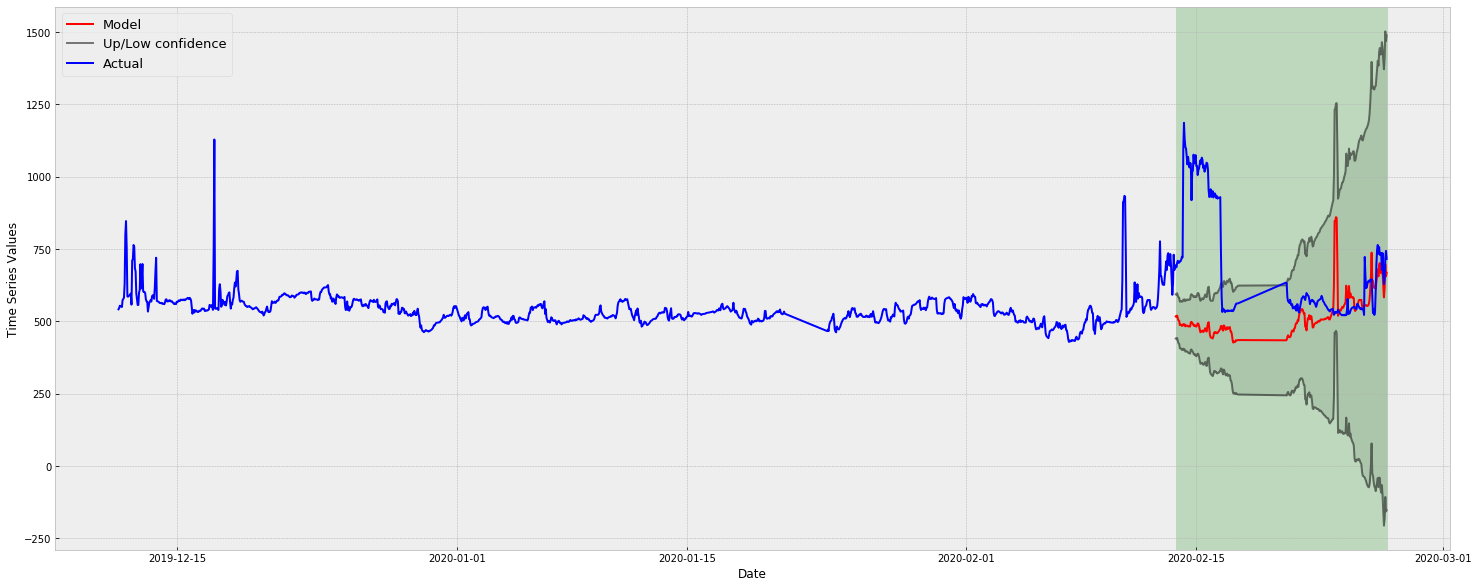

In [6]:
sensor_name = 'sensor 1'
sensor_1 = dataSet[sensor_name]
Solution(sensor_1, sensor_name, 24*10).solveForecastTask()

0.001220947154942864 0.0313834523080449 0.8237086879164737
R2:  -0.42608086092391173
MSE:  14037.09884500984


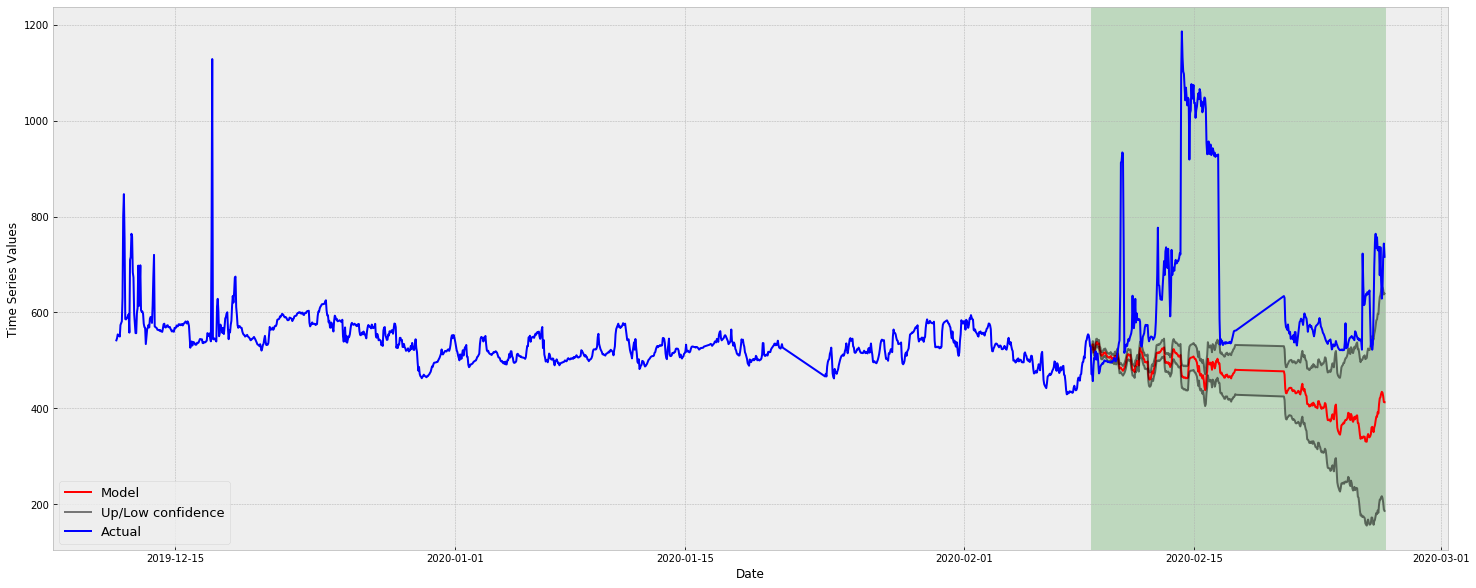

In [7]:
sensor_name = 'sensor 1'
sensor_1 = dataSet[sensor_name]
Solution(sensor_1, sensor_name, 24 * 15).solveForecastTask()

## Sensor 2

0.0034011472119576114 0.00977174228198563 0.5447127483870621
R2:  0.6235830545430499
MSE:  52.08899869650691


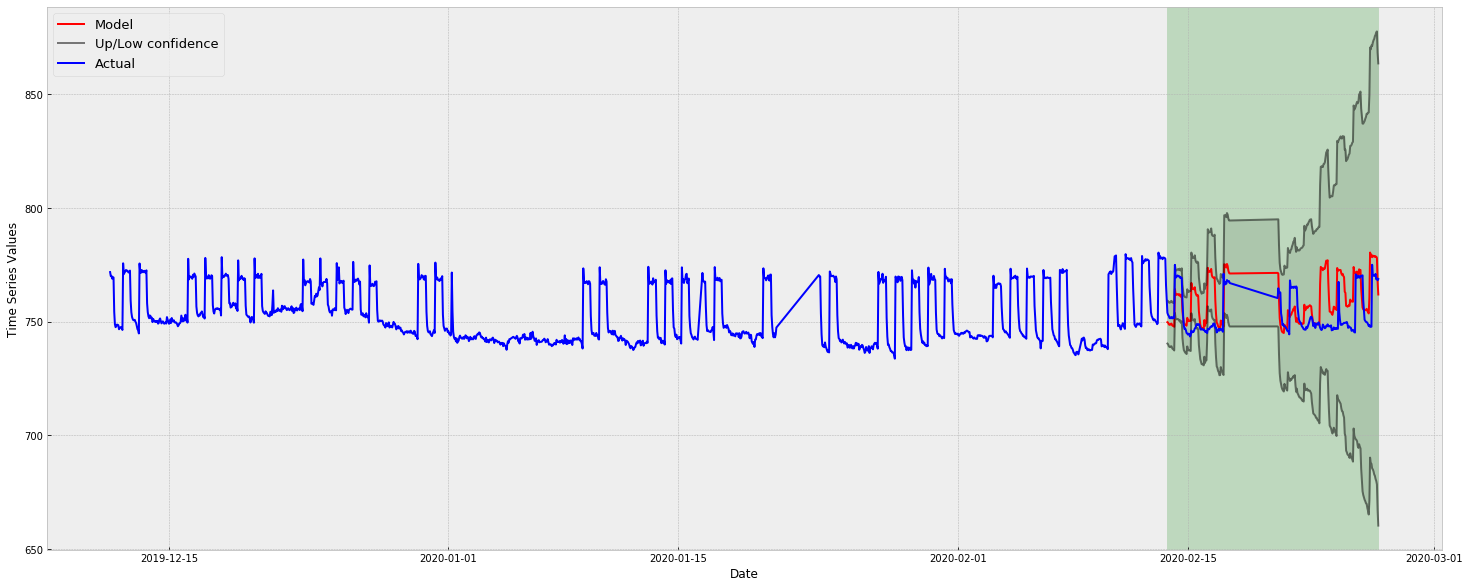

In [8]:
sensor_name2 = 'sensor 2'
sensor_2 = dataSet[sensor_name2]
Solution(sensor_2, sensor_name2, 24 * 10).solveForecastTask()

0.0034011472119576114 0.00977174228198563 0.5447127483870621
R2:  0.6035037760577148
MSE:  54.86759175261849


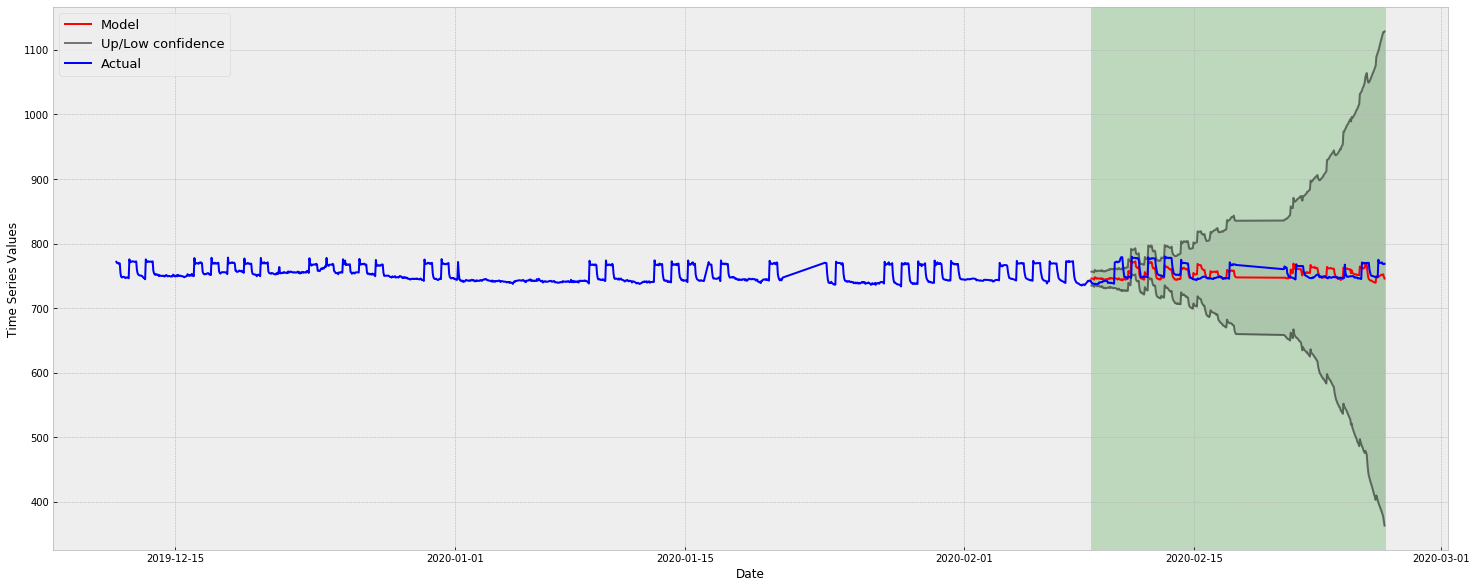

In [9]:
sensor_name2 = 'sensor 2'
sensor_2 = dataSet[sensor_name2]
Solution(sensor_2, sensor_name2, 24 * 15).solveForecastTask()

## Sensor 3

0.3820606236335874 0.0034888889553175706 1.0
R2:  0.37476272596549376
MSE:  40.747605339953466


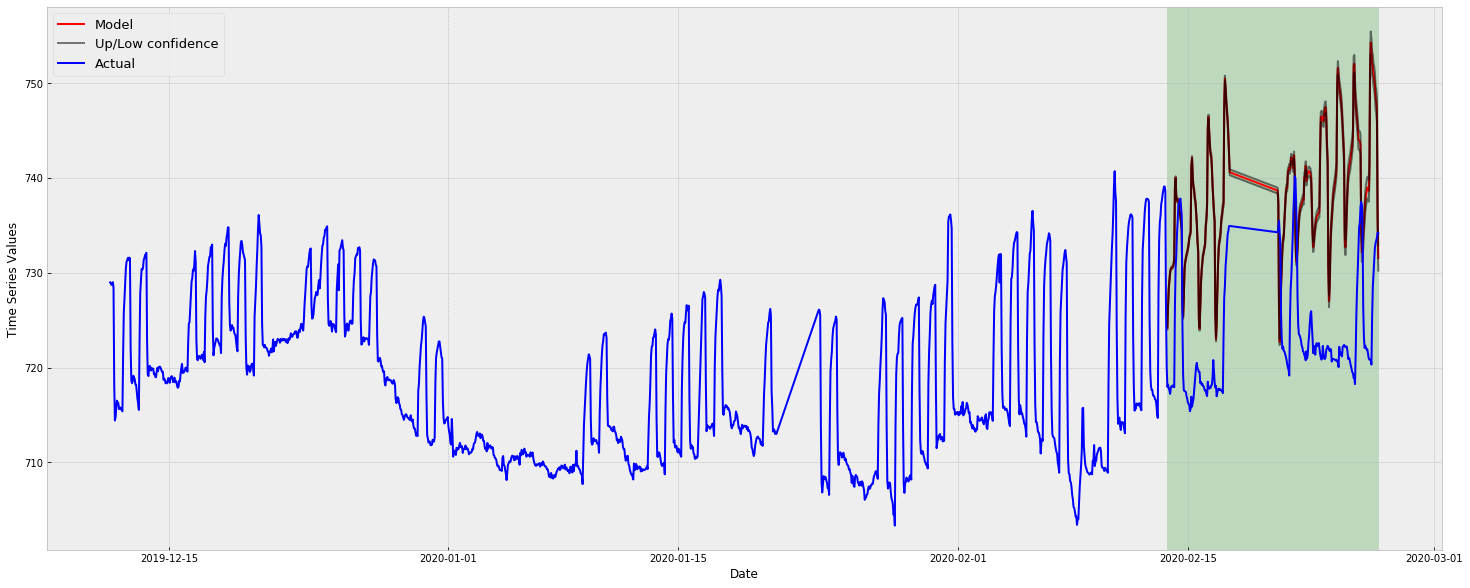

In [10]:
sensor_name3 = 'sensor 3'
sensor_3 = dataSet[sensor_name3]
Solution(sensor_3, sensor_name3, 24 * 10).solveForecastTask()

0.3820606236335874 0.0034888889553175706 1.0
R2:  0.5000665062481864
MSE:  32.58137917493821


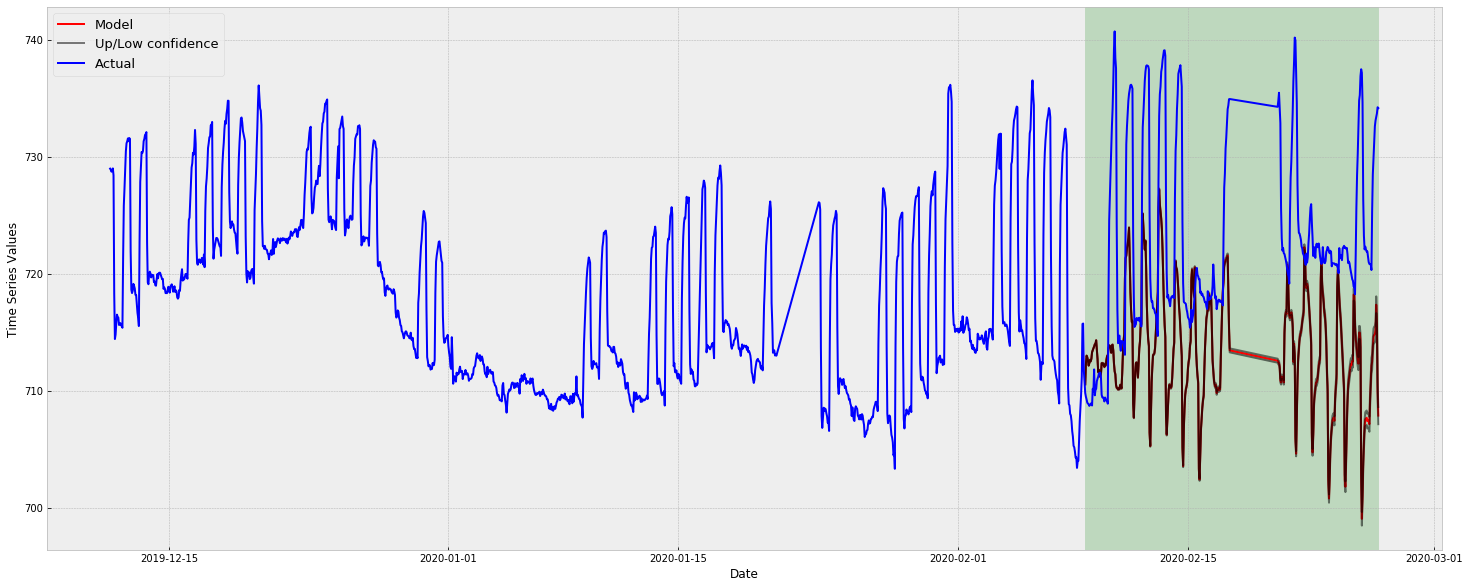

In [11]:
sensor_name3 = 'sensor 3'
sensor_3 = dataSet[sensor_name3]
Solution(sensor_3, sensor_name3, 24 * 15).solveForecastTask()

## Sensor 4

0.0 0.0 0.0
R2:  -0.4379622712714699
MSE:  406.984566770796


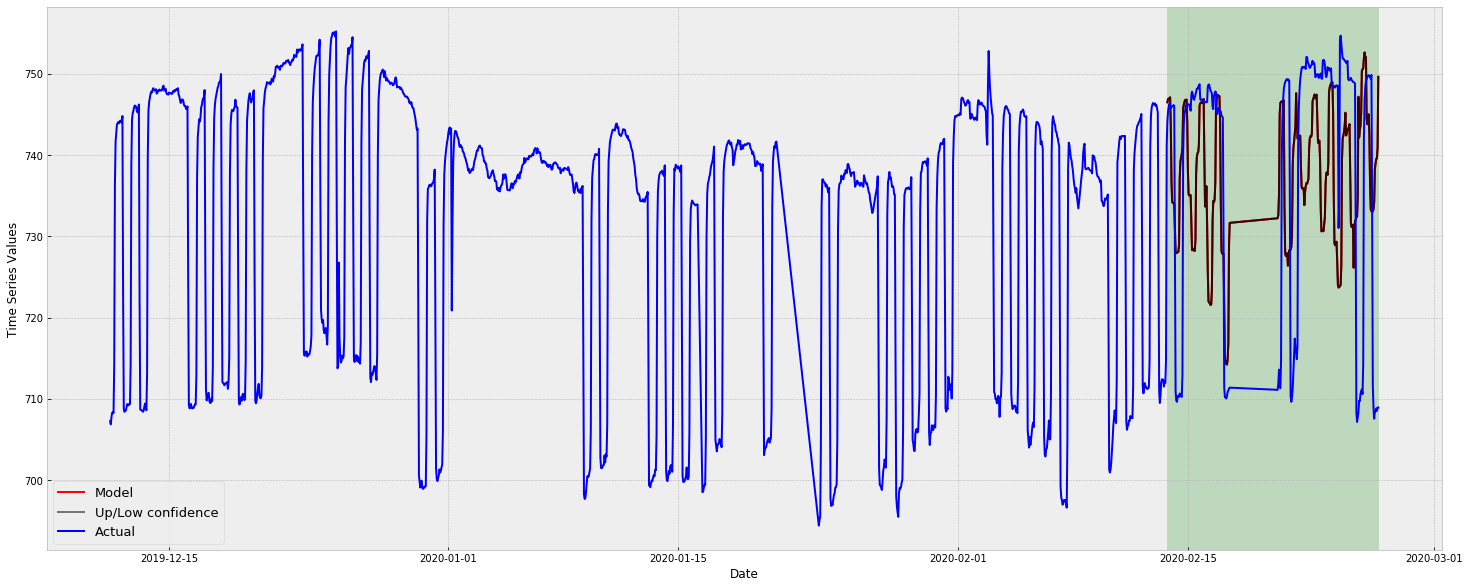

In [12]:
sensor_name4 = 'sensor 4'
sensor_4 = dataSet[sensor_name4]
Solution(sensor_4, sensor_name4, 24*10).solveForecastTask()

0.0 0.0 0.0
R2:  -2.283769007905501
MSE:  929.4008151382733


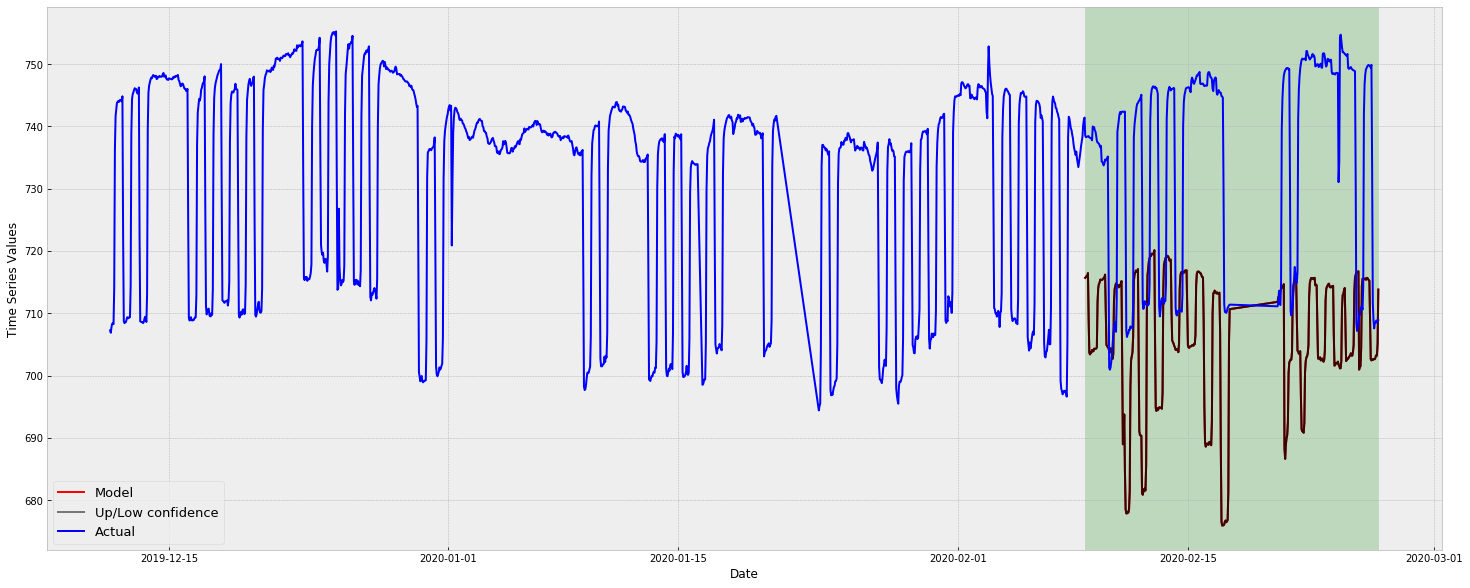

In [13]:
predict_period = 24 * 15
sensor_name4 = 'sensor 4'
sensor_4 = dataSet[sensor_name4]
Solution(sensor_4, sensor_name4, predict_period).solveForecastTask()

## Sensor 5

0.017117898237917595 0.0 0.4933949984307676
R2:  0.638925714900353
MSE:  289.16304601943995


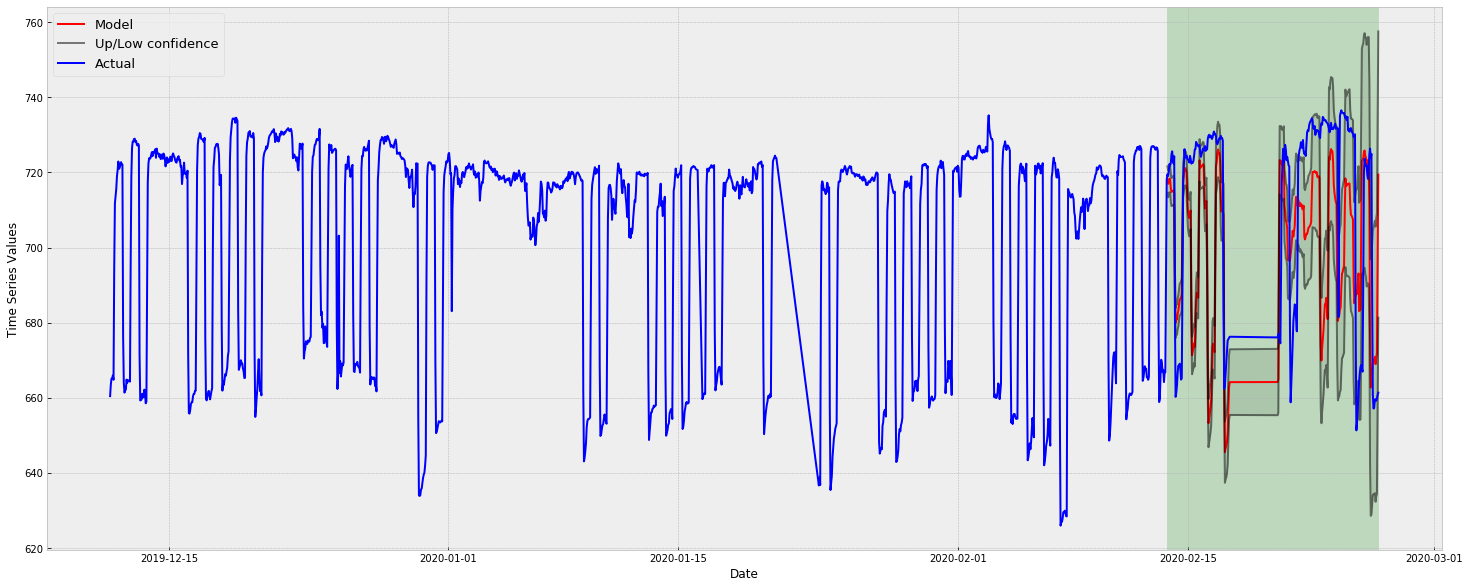

In [14]:
sensor_name5 = 'sensor 5'
sensor_5 = dataSet[sensor_name5]
Solution(sensor_5, sensor_name5, 24*10).solveForecastTask()

0.017117898237917595 0.0 0.4933949984307676
R2:  0.5856174502382085
MSE:  331.85448327718336


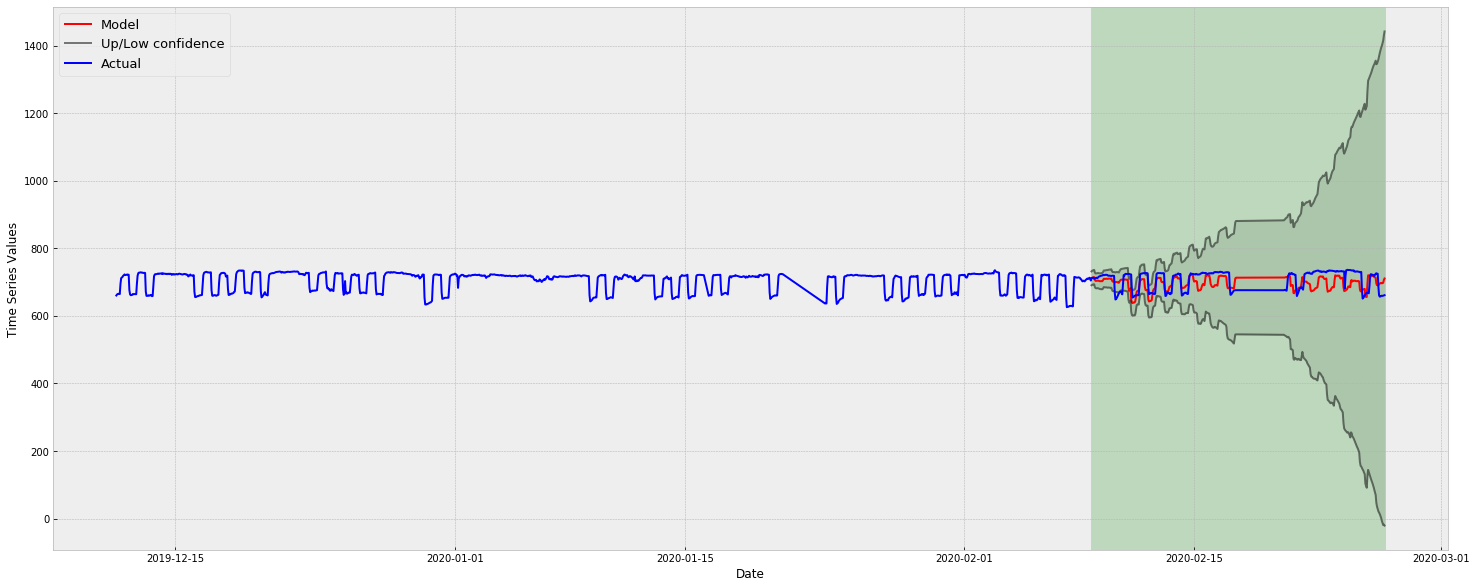

In [15]:
predict_period = 24 * 15
sensor_name5 = 'sensor 5'
sensor_5 = dataSet[sensor_name5]
Solution(sensor_5, sensor_name5, predict_period).solveForecastTask()

## Sensor 6

0.02252925487678803 0.0 0.4288206683649891
R2:  0.5806822319837399
MSE:  100.08674217427064


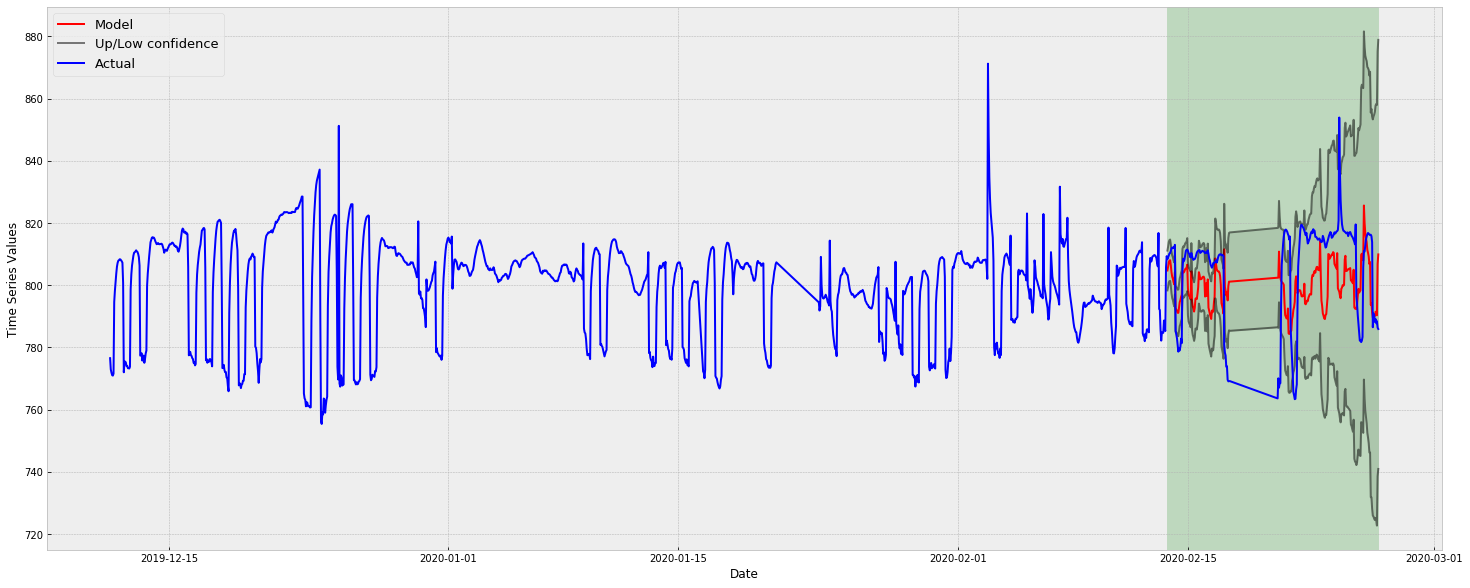

In [16]:
sensor_name6 = 'sensor 6'
sensor_6 = dataSet[sensor_name6]
Solution(sensor_6, sensor_name6, 24*10).solveForecastTask()

0.02252925487678803 0.0 0.4288206683649891
R2:  0.541101583374283
MSE:  109.53422681391869


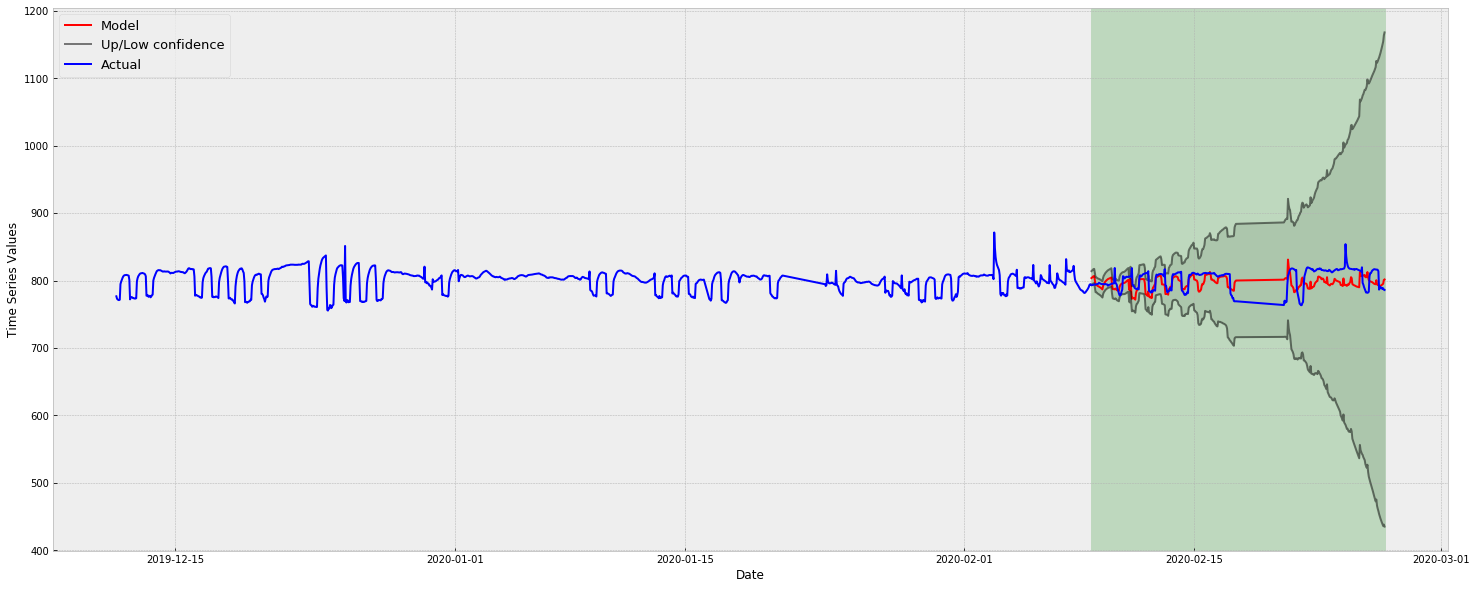

In [17]:
predict_period = 24 * 15
sensor_name6 = 'sensor 6'
sensor_6 = dataSet[sensor_name6]
Solution(sensor_6, sensor_name6, predict_period).solveForecastTask()

## Sensor 8

0.00021983669920716542 0.12054000459657455 0.030828315442241794
R2:  0.5910686481066567
MSE:  14172.203742377082


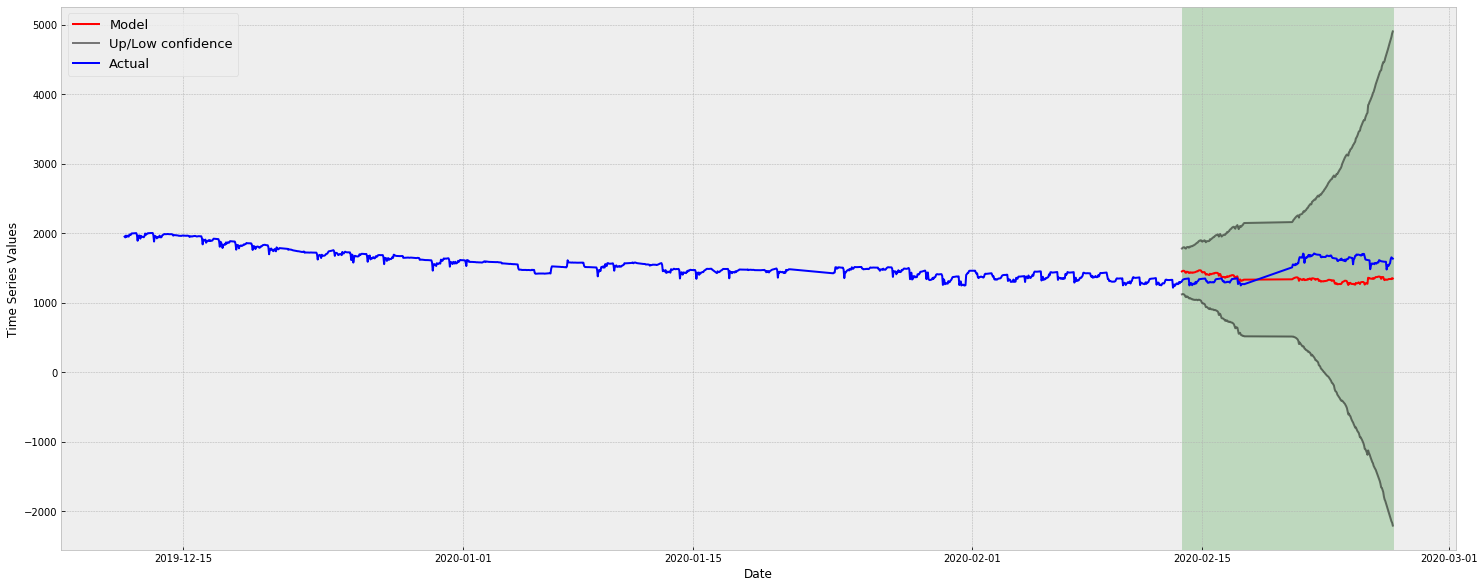

In [18]:
sensor_name8 = 'sensor 8'
sensor_8 = dataSet[sensor_name8]
Solution(sensor_8, sensor_name8, 24*10).solveForecastTask()

0.00021983669920716542 0.12054000459657455 0.030828315442241794
R2:  0.5927150194846111
MSE:  14115.145973399583


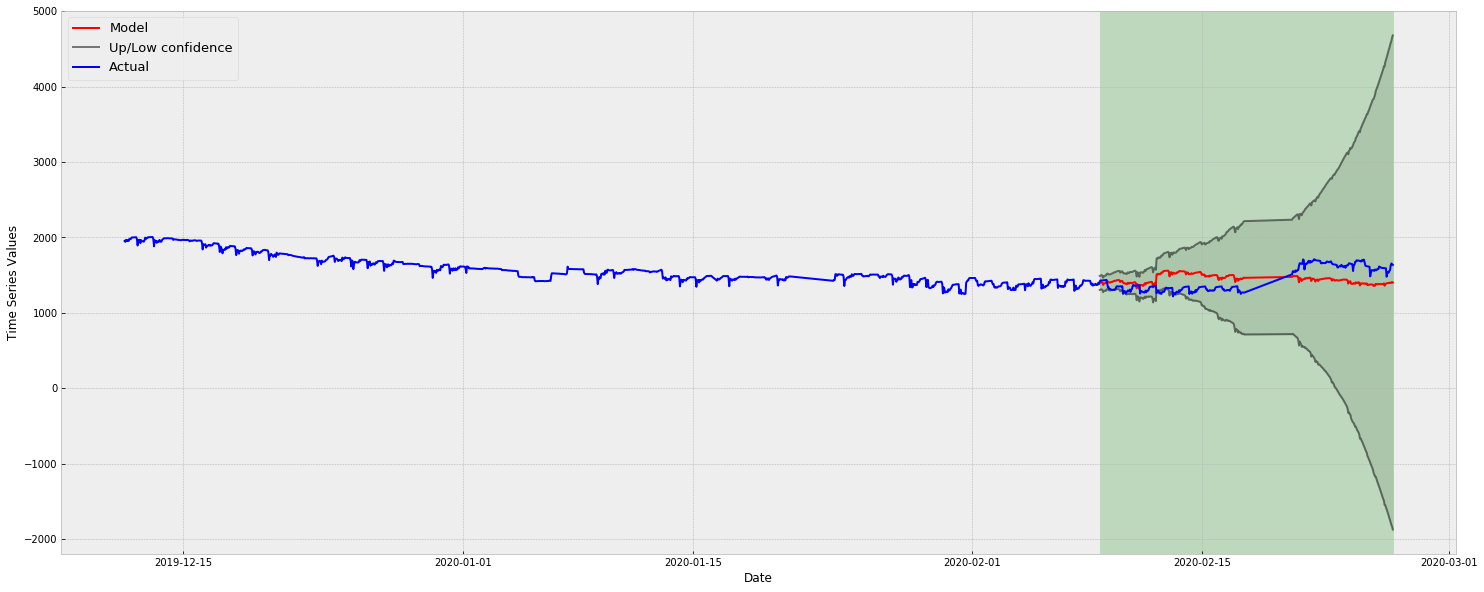

In [19]:
predict_period = 24 * 15
sensor_name8 = 'sensor 8'
sensor_8 = dataSet[sensor_name8]
Solution(sensor_8, sensor_name8, predict_period).solveForecastTask()

## Sensor 9

0.008097183376111539 0.03638281423395345 0.1545630693267031
R2:  0.1685402178956985
MSE:  28362.325300917808


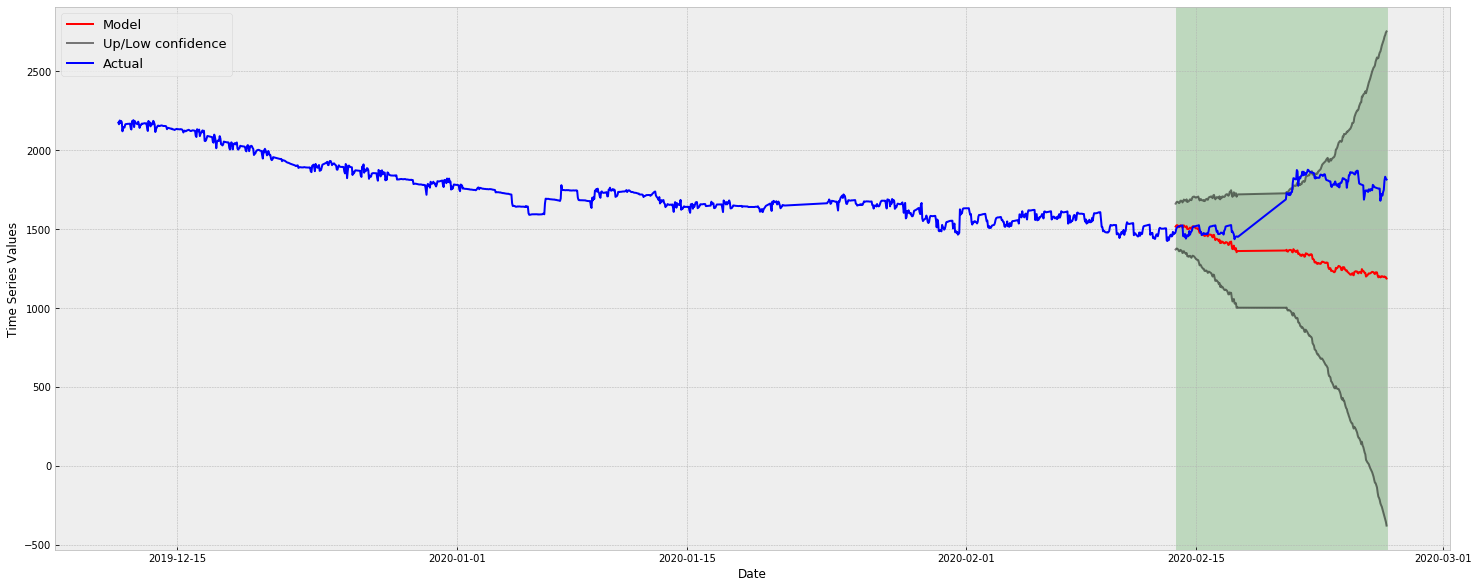

In [20]:
sensor_name9 = 'sensor 9'
sensor_9 = dataSet[sensor_name9]
Solution(sensor_9, sensor_name9, 24*10).solveForecastTask()

0.008097183376111539 0.03638281423395345 0.1545630693267031
R2:  -2.128311360272701
MSE:  106711.33631750438


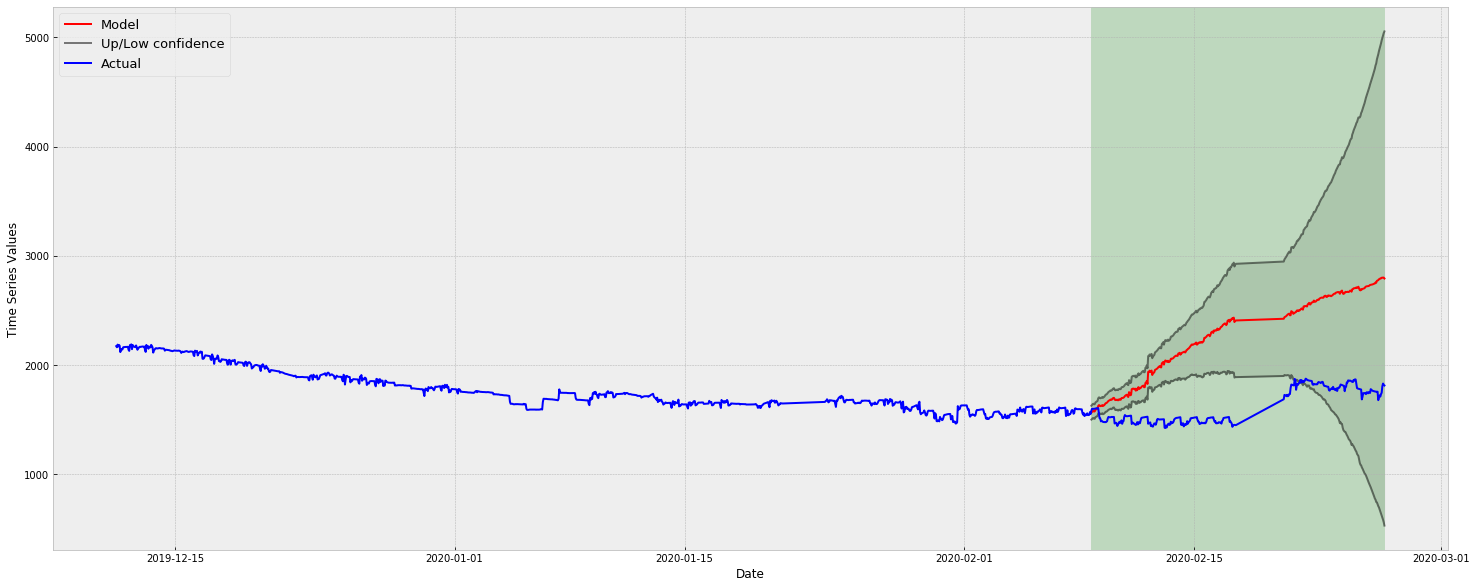

In [21]:
predict_period = 24 * 15
sensor_name9 = 'sensor 9'
sensor_9 = dataSet[sensor_name9]
Solution(sensor_9, sensor_name9, predict_period).solveForecastTask()